In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
clear_output()

def plot_func_2d(ax, f, lb=(-1., -1.), ub=(1., 1.), step=(0.1, 0.1)):
    with torch.no_grad():
        x = torch.arange(lb[0], ub[0], step[0])
        y = torch.arange(lb[1], ub[1], step[1])
        X, Y = torch.meshgrid(x, y)
        X_batch = get_2d_batch(x, y)
        Z = torch.zeros(X_batch.size()[:-1])
        for i in range(X_batch.size(0)):
            for j in range(X_batch.size(1)):
                Z[i, j] = f(X_batch[i, j])
        # Z = f(X_batch)
        ax.contour(X, Y, Z)

def plot_vp(ax, vp, lb=(-1., -1.), ub=(1., 1.), step=(0.1, 0.1)):
    plot_func_2d(ax, vp.q, lb, ub, step)
    mu_x = [m[0].item() for m in vp.mu]
    mu_y = [m[1].item() for m in vp.mu]
    ax.scatter(mu_x, mu_y, color='red')

def plot_vp_gp_f(vp, f, gp, points, lb=(-1., -1.), ub=(1., 1.), step=(0.1, 0.1)):
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
    ax[0].set_title('Variational Posterior')
    ax[1].set_title('GP model')
    ax[2].set_title('log joint distribution')
    plot_vp(ax[0], vp, lb, ub, step)
    plot_func_2d(ax[1], gp.posterior_mean, lb, ub, step)
    plot_func_2d(ax[2], f, lb, ub, step)
    # ax[0].scatter(*points, color='black')
    # ax[1].scatter(*points, color='black')

In [3]:
def get_2d_batch(x, y):
    X_batch = torch.zeros((x.size(0), y.size(0), 2))
    for i in range(x.size(0)):
        for j in range(y.size(0)):
            X_batch[i, j, 0] = x[i]
            X_batch[i, j, 1] = y[j]
    return X_batch

In [4]:
def log_gaussian(x, mean, logvar, dim=None):
    log_normal = -0.5 * (math.log(2.0*math.pi) + logvar + 
                         torch.pow(x - mean, 2) / (logvar.exp()+1e-5))
    return log_normal.sum(dim)

In [5]:
def exp_sum(*tensors):
    return torch.logsumexp(torch.cat([t.unsqueeze(0) for t in tensors]), 0)

In [6]:
class GPModel():
    def __init__(self, D):
        self.D = D
        self.n = 0
        self.X = None
        self.y = None
        self.C = None
        self.inv_C = None
        
        # parameters 3D + 3
        self.log_sigma_out = torch.tensor(math.log(1.))
        self.log_sigma_in = -1 * torch.ones(D)
        self.m_0 = torch.tensor(0.01)
        self.x_m = torch.zeros(D)
        self.omega = torch.ones(D) * 10
        self.sigma_obs = torch.tensor(0.001)

    def mean(self, x):
        m = self.m_0 - 0.5 * torch.sum(((x - self.x_m) / self.omega).pow(2))
        return m

    def kernel(self, x_1, x_2):
        # pos = -2
        # if len(x_1.size()) < 2:
        #     pos = 0
        # for i in range(len(x_2.size()) - 1):
        #     x_1 = x_1.unsqueeze(pos)
        K = math.pi ** (self.D / 2) * torch.exp(self.log_sigma_out.sum() / 2 + log_gaussian(x_1, x_2, self.log_sigma_in, dim=-1))
        K *= torch.exp(self.log_sigma_out)
        return K

    def posterior_mean(self, x):
        m = self.mean(x)
        k = self.kernel(x, self.X)
        f = k @ (self.inv_C @ (self.y - m)) + m
        return f
    
    def posterior_covariance(self, x_1, x_2):
        k_1 = self.kernel(x_1, self.X)
        k_2 = self.kernel(self.X, x_2)
        C = self.kernel(x_1, x_2) - k_1 @ (self.inv_C @ k_2)
        return C

    def add_point(self, x, y):
        raise NotImplementedError()

    def set_data(self, X, y):
        '''
            Sets data points X, y
            X - tensor (n, D)
            y - tensor (n,)
        '''
        assert X.size(1) == self.D
        self.X = X
        self.y = y
        self.n = X.size(0)
        self.C = torch.zeros(self.n, self.n)
        for i in range(self.n):
            self.C[i] = self.kernel(X[i], X)
        self.C = self.C + self.sigma_obs * torch.eye(self.n)
        self.inv_C = torch.inverse(self.C)






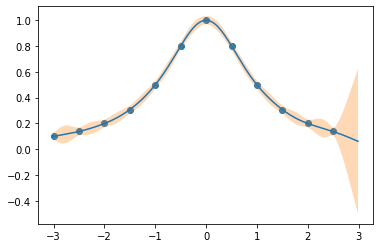

In [7]:
X = torch.arange(-3, 3, 0.5).unsqueeze(0).T
y = 1 / (1 + (X * X).sum(1))

gp = GPModel(1)
gp.set_data(X, y)

plt.scatter(X, y)
x_range = torch.arange(-3, 3, 0.01)
y_pred = torch.tensor([gp.posterior_mean(x) for x in x_range])
y_error = torch.tensor([gp.posterior_covariance(x, x) ** 0.5 for x in x_range])
y_high = y_pred + y_error
y_low = y_pred - y_error
plt.plot(x_range, y_pred)
plt.fill_between(x_range, y_high, y_low, alpha=0.3)

In [8]:
def test_gp_func(x):
    return 1 / (1 + (x * x).sum(-1))

torch.Size([30, 30, 2])
torch.Size([900, 2])


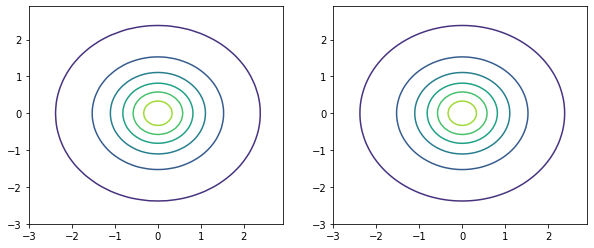

In [9]:
x_1 = torch.arange(-3, 3, 0.2)
x_2 = torch.arange(-3, 3, 0.2)
X_batch = get_2d_batch(x_1, x_2)
print(X_batch.size())
X = X_batch.reshape(-1, 2)
print(X.size())
y = test_gp_func(X)
gp = GPModel(2)
gp.set_data(X, y)
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
plot_func_2d(ax[0], gp.posterior_mean, lb=(-3., -3.), ub=(3., 3.))
plot_func_2d(ax[1], test_gp_func, lb=(-3., -3.), ub=(3., 3.))
plt.show()

In [10]:
class VariationalPosterior():
    def __init__(self, x_0, K=2, L_scale=1.0, sigma_scale=1.0):
        L_scale = torch.tensor(L_scale, dtype=torch.float32)
        sigma_scale = torch.tensor(sigma_scale, dtype=torch.float32)
        self.D = x_0.size(0)
        self.K = K
        self.w = [torch.tensor([1.], requires_grad=True) for i in range(self.K)]
        self.log_sigma = [torch.tensor([0.0]) + torch.log(sigma_scale) for i in range(self.K)]
        self.log_sigma = [t.requires_grad_(True) for t in self.log_sigma]
        self.mu = [2 * L_scale ** 0.5 * torch.randn(self.D) + x_0 for i in range(self.K)]
        self.mu = [t.requires_grad_(True) for t in self.mu]
        self.log_L = torch.zeros(self.D) + torch.log(L_scale)
        self.log_L = self.log_L.requires_grad_(True)

    def q(self, x):
        w = self.get_weights()
        q = 0
        for i in range(self.K):
            q += w[i] * torch.exp(log_gaussian(x, self.mu[i], self.log_sigma[i] + self.log_L, dim=-1))
        return q
    
    def remove_comp(self, idx):
        w = self.w.pop(idx)
        log_sigma = self.log_sigma.pop(idx)
        mu = self.mu.pop(idx)
        self.K -= 1
        return w, log_sigma, mu

    def add_comp(self, new_w, new_log_sigma, new_mu):
        self.w.append(new_w)
        self.log_sigma.append(new_log_sigma)
        self.mu.append(new_mu)
        self.K += 1

    def add_random_comp(self):
        k = torch.randint(self.K, (1,))
        new_w = self.w[k].clone()
        new_log_sigma = self.log_sigma[k].clone()
        new_mu = 2 * torch.exp(0.5 * (self.log_L.detach() + self.log_sigma[k].detach())) * torch.randn(self.D, requires_grad=True) + self.mu[k].detach()
        self.add_comp(new_w, new_log_sigma, new_mu)

    def parameters(self):
        params = [*self.w, *self.mu, *self.log_sigma, self.log_L]
        return params

    def get_weights(self):
        return torch.softmax(torch.cat(self.w), 0)

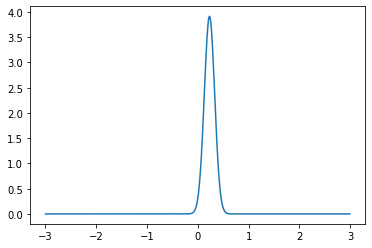

In [11]:
# 1d
x_0 = torch.zeros(1)
vp = VariationalPosterior(x_0, K=3, L_scale=0.01)
with torch.no_grad():
    X = torch.arange(-3, 3, 0.01).unsqueeze(0).T
    y = vp.q(X)
    plt.plot(X, y)

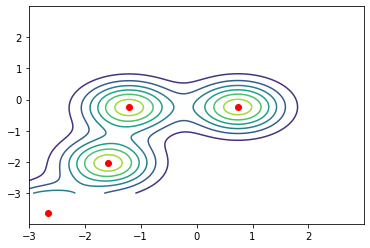

In [12]:
# 2d
x_0 = torch.zeros(2)
vp = VariationalPosterior(x_0, L_scale=.3)
for i in range(2):
    vp.add_random_comp()
with torch.no_grad():
    x = torch.arange(-3, 3, 0.01)
    y = torch.arange(-3, 3, 0.01)
    X, Y = torch.meshgrid(x, y)
    X_batch = get_2d_batch(x, y)
    Z = vp.q(X_batch)
    plt.contour(X, Y, Z)
    m_x = []
    m_y = []
    for mu in vp.mu:
        m_x.append(mu[0].item())
        m_y.append(mu[1].item())
    plt.scatter(m_x, m_y, color='red')

In [13]:
a = torch.ones(5)
b = torch.linspace(1., 5, 5)
c_1 = torch.log(torch.exp(a) + torch.exp(b))
c_2 = exp_sum(a, b)
print(c_1 - c_2)

tensor([ 0.0000e+00,  0.0000e+00, -2.3842e-07,  0.0000e+00,  0.0000e+00])


In [14]:
class ELCBO():
    def __init__(self, beta=3):
        self.beta = beta
    
    def elbo(self, vp, gp):
        return self.e(vp, gp) + self.h(vp)
    
    def elcbo(self, vp, gp):
        return self.elbo(vp, gp) - self.beta * (self.v(vp, gp)).pow(0.5)

    def e(self, vp, gp):
        result = 0
        w = vp.get_weights()
        for k in range(vp.K):
            y = gp.y
            X = gp.X
            m = gp.mean(X)
            m_0 = gp.m_0
            inv_C = gp.inv_C
            
            z = self.z_value(vp, gp, k)
            v = self.v_value(vp, gp, k)
            result += w[k] * (z @ (inv_C @ (y - m)) + m_0 + v)
        return result

    def h(self, vp, n_s = 100):
        w = vp.get_weights()
        eps = torch.randn(n_s, vp.K, vp.D)
        r = torch.exp(vp.log_L / 2)
        mu = torch.cat([m.unsqueeze(0) for m in vp.mu])

        sigma = torch.exp(torch.cat(vp.log_sigma) / 2).unsqueeze(0).unsqueeze(2)
        xi = sigma * eps * r + mu
        psi = (torch.log(vp.q(xi)) @ w).mean()
        return psi

    def v(self, vp, gp):
        result = 0
        w = vp.get_weights()
        for j in range(vp.K):
            for k in range(vp.K):
                mu_j = vp.mu[j]
                mu_k = vp.mu[k]
                log_sigma_j = vp.log_sigma[j]
                log_sigma_k = vp.log_sigma[k]
                log_L = vp.log_L
                log_sigma_in = gp.log_sigma_in
                log_sigma_out = gp.log_sigma_out
                inv_C = gp.inv_C

                s = exp_sum(
                    log_L + log_sigma_j,
                    log_L + log_sigma_k,
                    log_sigma_in
                )

                z_j = self.z_value(vp, gp, j)
                z_k = self.z_value(vp, gp, k)

                J = torch.exp(log_sigma_out + log_gaussian(mu_j, mu_k, s, -1)) - z_j @ (inv_C @ z_k)
                result += w[j] * w[k] * J
        return result

    def z_value(self, vp, gp, k):
        log_sigma = vp.log_sigma[k]
        log_L = vp.log_L
        mu = vp.mu[k]

        X = gp.X
        log_sigma_in = gp.log_sigma_in
        log_sigma_out = gp.log_sigma_out
        s = exp_sum(log_sigma + log_L, log_sigma_in)
        z = torch.exp(log_sigma_out + log_gaussian(mu, X, s, -1))
        return z

    def v_value(self, vp, gp, k):
        log_sigma = vp.log_sigma[k]
        log_L = vp.log_L
        mu = vp.mu[k]

        x_m = gp.x_m
        omega = gp.omega

        v = ((mu - x_m).pow(2) + torch.exp(log_sigma + log_L)) / omega.pow(2)
        v = -0.5 * (v).sum(0)
        return v

In [15]:
X = torch.randn(2000, 2)
y = torch.log(0.003 / (1 + (X * X).sum(-1)))
print(y)

gp = GPModel(2)
gp.set_data(X, y)

x_0 = torch.zeros(2)
vp = VariationalPosterior(x_0, L_scale=.3)
for i in range(2):
    vp.add_random_comp()

elcbo = ELCBO()
print(elcbo.e(vp, gp).item())
print(elcbo.v(vp, gp).item())

tensor([-6.7322, -6.5732, -6.6309,  ..., -6.4542, -6.3922, -6.6350])
3.4523472785949707
0.038094744086265564


In [16]:
s_0 = torch.linspace(1., 2, 2)
a = torch.randn(10, 2, 5)
s = s_0.unsqueeze(0)
s = s.unsqueeze(2)
s.size()
c_1 = a * s
c_2 = torch.zeros_like(a)
for i in range(a.size(0)):
    for j in range(a.size(2)):
        c_2[i, :, j] = a[i, :, j] * s_0
print(torch.allclose(c_1, c_2))

True


In [17]:
elcbo.h(vp)

tensor(-2.7629, grad_fn=<MeanBackward0>)

In [18]:
class GaussianMixture():
    def __init__(self, n):
        self.n = n
        self.mean = torch.rand(n, 2)
        weights = torch.rand(n)
        self.weights = weights / weights.sum()
        self.log_sigma = 3 * torch.rand(n, 2) - 5

    def __call__(self, x):
        return self.pdf(x)

    def pdf(self, x):
        result = 0
        for i in range(self.n):
            result += self.weights[i] * torch.exp(log_gaussian(x, self.mean[i], self.log_sigma[i], -1))
        return result

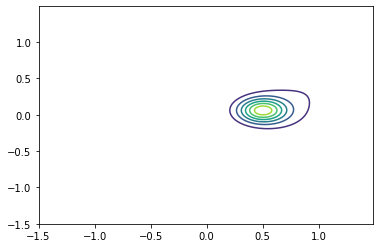

In [27]:
gm = GaussianMixture(3)
x = torch.arange(-1.5, 1.5, 0.01)
y = torch.arange(-1.5, 1.5, 0.01)
X, Y = torch.meshgrid(x, y)
X_batch = get_2d_batch(x, y)
Z = gm(X_batch)
plt.contour(X, Y, Z)

In [28]:
class AcquisitionPRO():
    def __init__(self, vp, gp, v_red=1e-4):
        self.vp = vp
        self.gp = gp
        self.v_reg = v_reg
    
    def __call__(self, x):
        return self.a(x)
    
    def a(self, x):
        V = self.gp.posterior_covariance(x, x)
        f = self.gp.posterior_mean(x)
        q = self.vp.q(x)
        return V * q * torch.exp(f) * torch.exp(-(self.v_reg / V - 1) * (V < v_reg))

class AcquisitionUS():
    def __init__(self, vp, gp, v_red=1e-4):
        self.vp = vp
        self.gp = gp
        self.v_reg = v_reg
    
    def __call__(self, x):
        return self.a(x)
    
    def a(self, x):
        V = self.gp.posterior_covariance(x, x)
        q = self.vp.q(x)
        return V * q.pow(2) * torch.exp(-(self.v_reg / V - 1) * (V < v_reg))

In [29]:
class EvalCounter():
    def __init__(self, c):
        self.c = c
        self.counter = 0
    
    def __call__(self, x):
        self.counter += 1
        return self.c(x)
    
    def num_evals(self):
        return self.counter

def VBMC(target, x_0, PBL, PBU, max_evals=1000):
    n_init=1000
    n_active = 5
    warm_up = True

    target_original = target
    target = EvalCounter(target)
    vp = VariationalPosterior(x_0, K=2)
    gp = GPModel(x_0.size(0))
    elcbo = ELCBO()

    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    plot_func_2d(ax[0], vp.q, lb=(-2., -2.), ub=(2., 2.))
    plot_func_2d(ax[1], target_original, lb=(-2., -2.), ub=(2., 2.))
    plt.show()

    x_0_s = x_0.unsqueeze(0)
    t = 0
    y_data = []
    x_data = []
    while True:
        t += 1
        if t == 1:
            y_0 = target(x_0_s)
            y_data.append(y_0)
            x_data.append(x_0_s)
            for i in range(n_init - 1):
                x = (PBU - PBL) * torch.rand_like(x_0_s) + PBL
                y = target(x)
                y_data.append(y)
                x_data.append(x)
            gp.set_data(torch.cat(x_data), torch.cat(y_data))
        else:
            pass
        # update number of components K
        v_hist = []
        if warm_up:
            params = vp.parameters()[vp.K:]
            optimizer = torch.optim.Adam(params, lr=0.01)
            for i in tqdm(range(1000)):
                optimizer.zero_grad()
                v = -elcbo.elbo(vp, gp)
                v_hist.append(-v.item())
                v.backward()
                optimizer.step()
        else:
            # full parameters
            # adaptive comp
            pass
        clear_output(wait=True)
        points = ([p[0, 0].item() for p in x_data], [p[0, 1].item() for p in x_data])
        plot_vp_gp_f(vp, target_original, gp, points, lb=(-2., -2.), ub=(2., 2.))
        plt.show()
        plt.title('ELBO vs iteration')
        plt.plot(v_hist)
        break
        # termination critiria
        if target.num_evals() >= max_evals:
            break

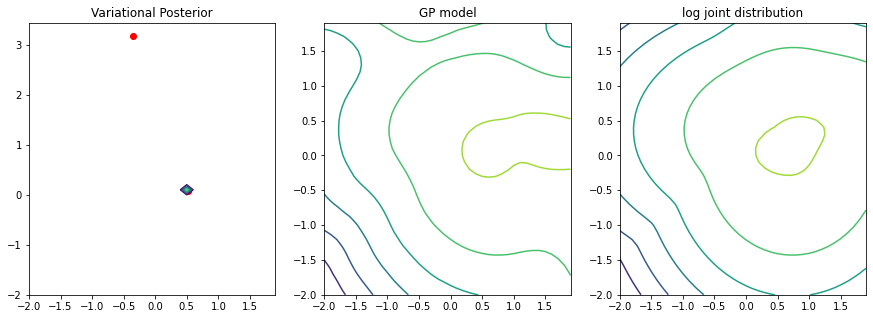

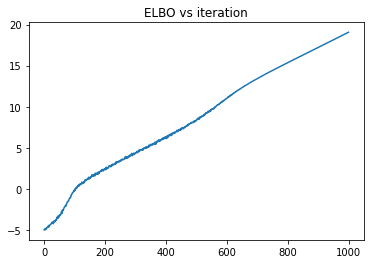

In [30]:
VBMC(lambda x: torch.log(3 * gm(x)), 2 * torch.ones(2), -2 * torch.ones(2), torch.ones(2))